In [41]:
import os
import zipfile

import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


making flowers directory

In [6]:
data_dir ="flowers"
print(os.listdir("flowers"))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


defining classes

For Data Loading we define parameters:

In [7]:
batch_size = 32
img_height = 128
img_width = 128

# Training the Model

Splitting Training and Validation Dataset

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


defining classes present in the flowers

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Visualizing 9 images from flower image dataset

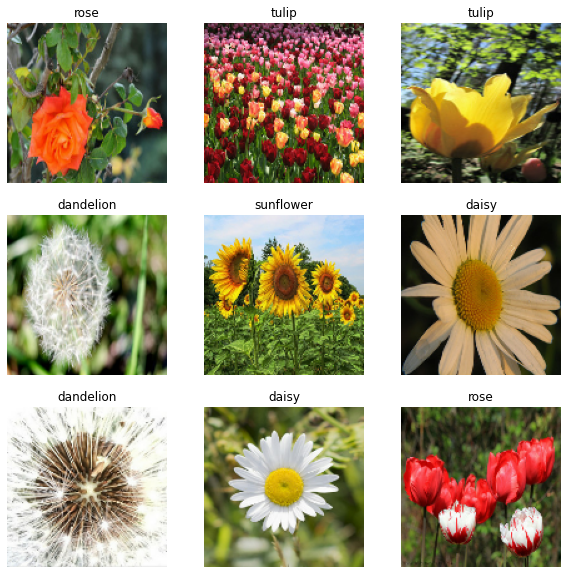

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8277526


In [16]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
108/108 [==============================] - 25s 217ms/step - loss: 1.3366 - accuracy: 0.4097 - val_loss: 1.0887 - val_accuracy: 0.5469
Epoch 2/10
108/108 [==============================] - 24s 222ms/step - loss: 1.0509 - accuracy: 0.5750 - val_loss: 1.0371 - val_accuracy: 0.5921
Epoch 3/10
108/108 [==============================] - 24s 222ms/step - loss: 0.9312 - accuracy: 0.6312 - val_loss: 0.9424 - val_accuracy: 0.6176
Epoch 4/10
108/108 [==============================] - 26s 245ms/step - loss: 0.8364 - accuracy: 0.6691 - val_loss: 0.8876 - val_accuracy: 0.6431
Epoch 5/10
108/108 [==============================] - 26s 237ms/step - loss: 0.7746 - accuracy: 0.6977 - val_loss: 0.8511 - val_accuracy: 0.6744
Epoch 6/10
108/108 [==============================] - 25s 229ms/step - loss: 0.6731 - accuracy: 0.7389 - val_loss: 0.8581 - val_accuracy: 0.6860
Epoch 7/10
108/108 [==============================] - 25s 233ms/step - loss: 0.5621 - accuracy: 0.7970 - val_loss: 0.8673 - val_ac

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [21]:
epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

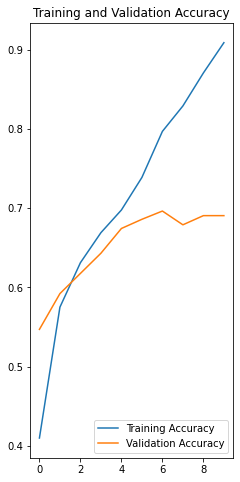

In [23]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



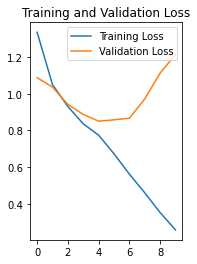

In [24]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

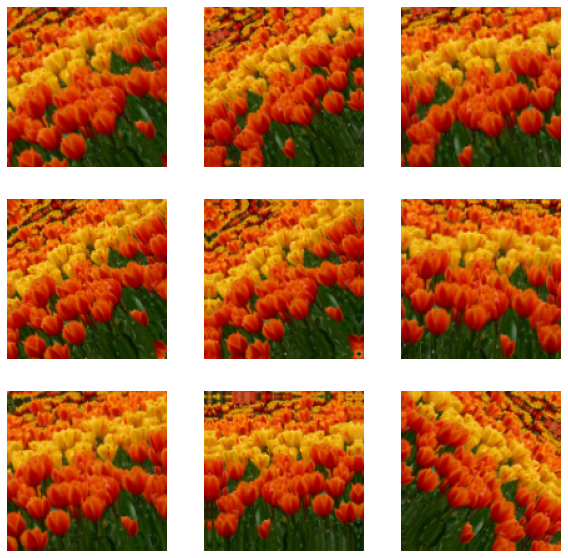

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
108/108 [==============================] - 30s 264ms/step - loss: 1.3618 - accuracy: 0.3903 - val_loss: 1.1253 - val_accuracy: 0.5319
Epoch 2/20
108/108 [==============================] - 28s 262ms/step - loss: 1.0682 - accuracy: 0.5715 - val_loss: 1.0086 - val_accuracy: 0.5944
Epoch 3/20
108/108 [==============================] - 29s 264ms/step - loss: 0.9522 - accuracy: 0.6184 - val_loss: 0.9313 - val_accuracy: 0.6304
Epoch 4/20
108/108 [==============================] - 29s 265ms/step - loss: 0.8693 - accuracy: 0.6705 - val_loss: 0.9214 - val_accuracy: 0.6280
Epoch 5/20
108/108 [==============================] - 29s 268ms/step - loss: 0.8302 - accuracy: 0.6821 - val_loss: 0.8473 - val_accuracy: 0.6732
Epoch 6/20
108/108 [==============================] - 29s 264ms/step - loss: 0.7950 - accuracy: 0.6922 - val_loss: 0.8353 - val_accuracy: 0.6860
Epoch 7/20
108/108 [==============================] - 28s 262ms/step - loss: 0.7660 - accuracy: 0.7128 - val_loss: 0.7929 - val_ac

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [32]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

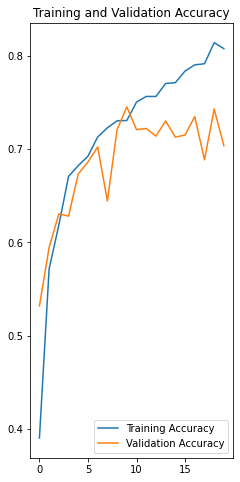

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


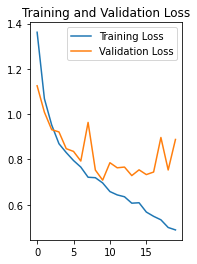

In [34]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

xepochs = [n for n in range(len(history.history['accuracy']))]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy over time", "Loss over time"))

for metric in ['accuracy', 'val_accuracy']:
    fig.add_trace(go.Scatter(x=xepochs, y=history.history[metric], mode='lines+markers', name=metric), row=1, col=1)

for metric in ['loss', 'val_loss']:
    fig.add_trace(go.Scatter(x=xepochs, y=history.history[metric], mode='lines+markers', name=metric), row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.show()

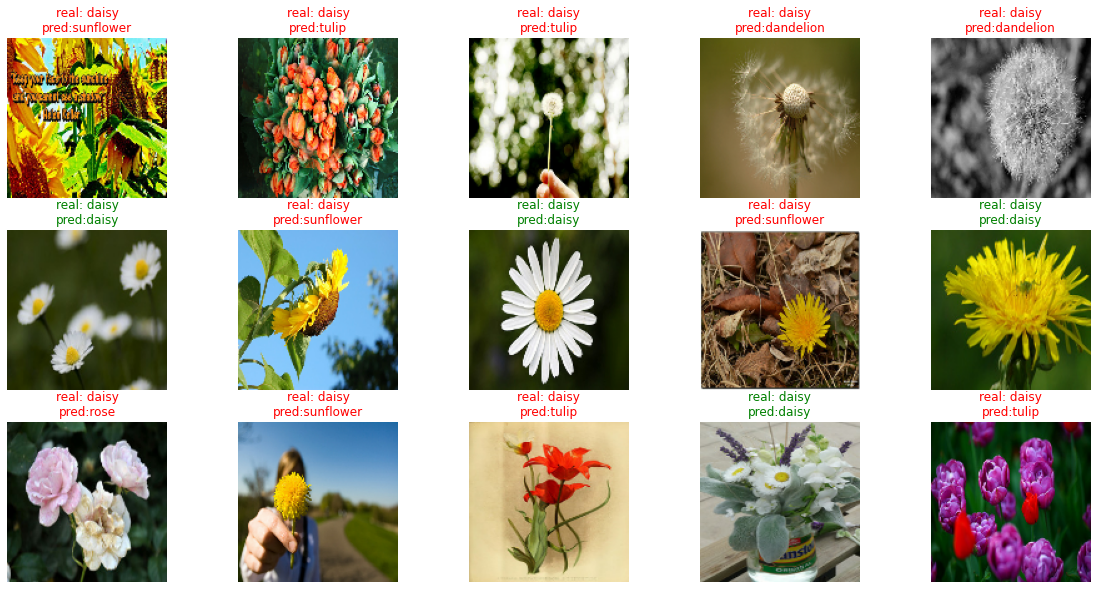

In [42]:
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        
        img_array = images[i].numpy().astype("uint8")
        prediction = model.predict(np.array([img_array]))
        prediction_name = class_names[np.argmax(prediction)]
        real_name = class_names[np.argmax(labels[i])]
        
        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})
        
        plt.axis("off")
